## Survey Depth Analysis with MAF

This notebook demonstrates how to perform a survey depth analysis using the **Metrics Analysis Framework (MAF)**. We compute the **5-sigma depth** for multiple filters (u, g, r, i, z, y) and visualize the results. Below is a step-by-step breakdown of the code.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading the Baseline Database and Extracting Simulation Information
opsdb = get_baseline()
opsim = os.path.basename(opsdb).replace('.db','')
print(opsdb,opsim)

/home/idies/rubin_sim_data/sim_baseline/baseline_v4.0_10yrs.db baseline_v4.0_10yrs


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 241 bins, returning 200
  warnings.warn(
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 325 bins, returning 200
  warnings.warn(
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 250 bins, returning 200
  warnings.warn(
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 200 bins, returning 200
  warnings.warn(


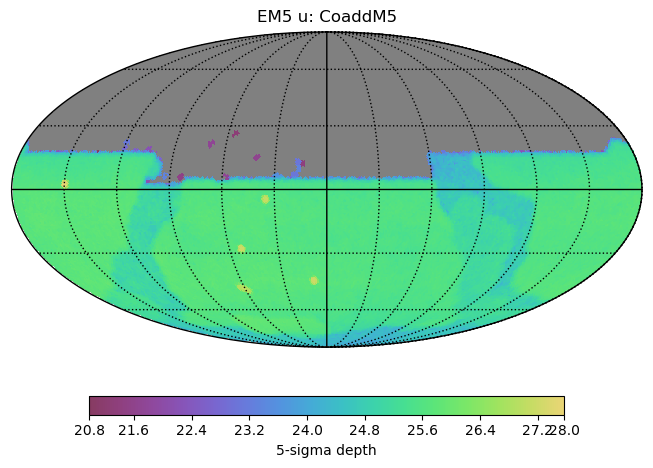

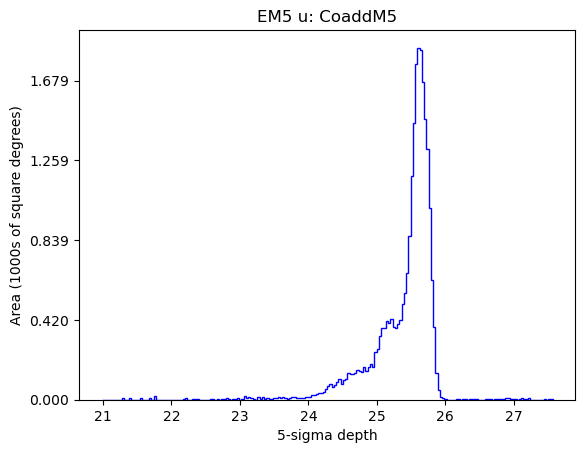

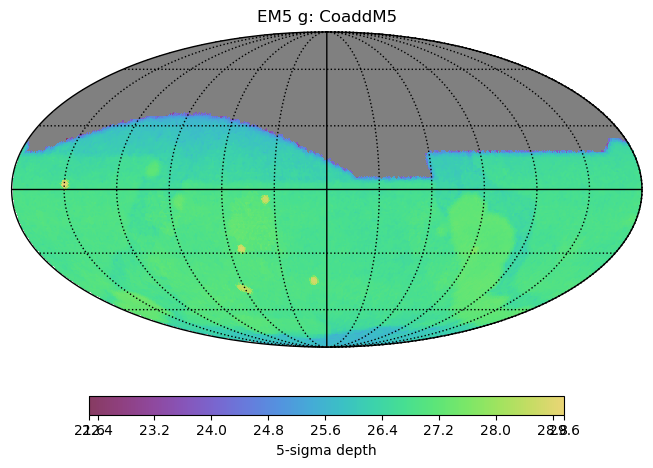

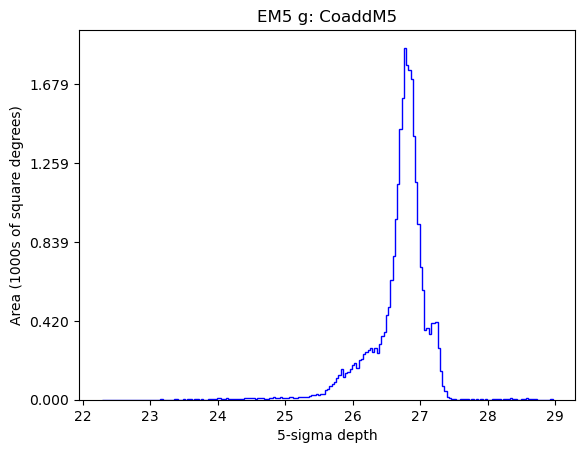

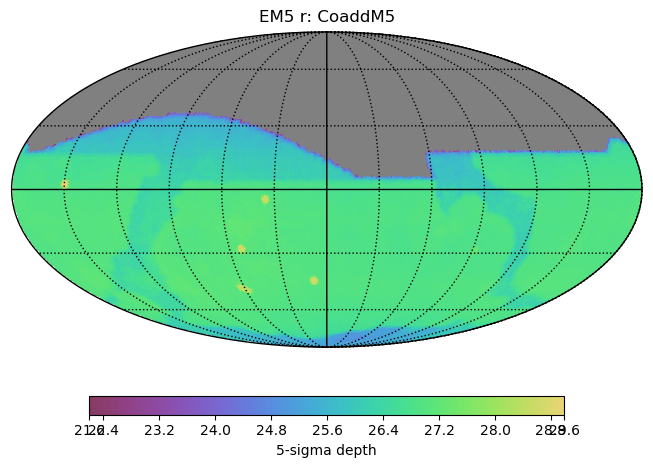

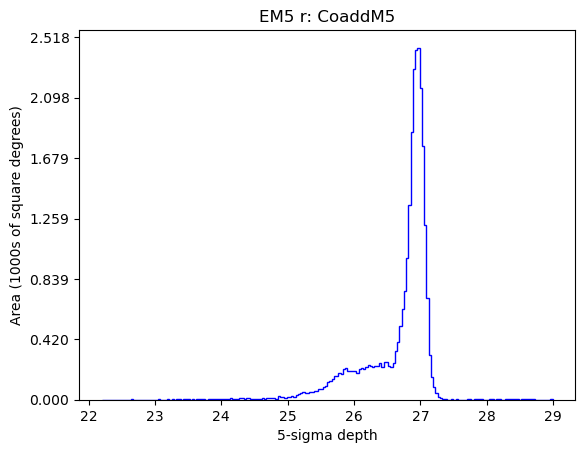

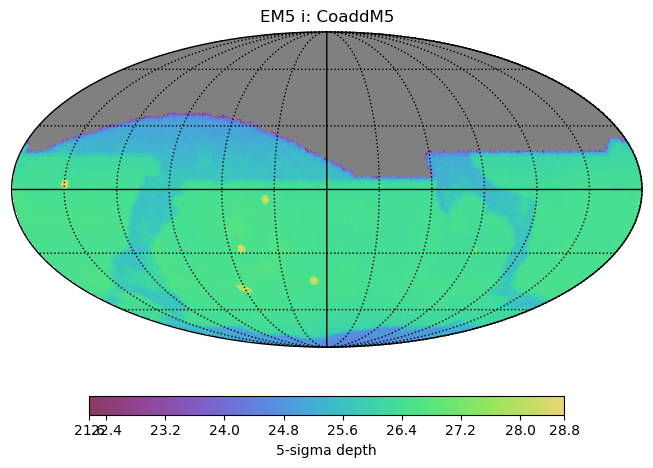

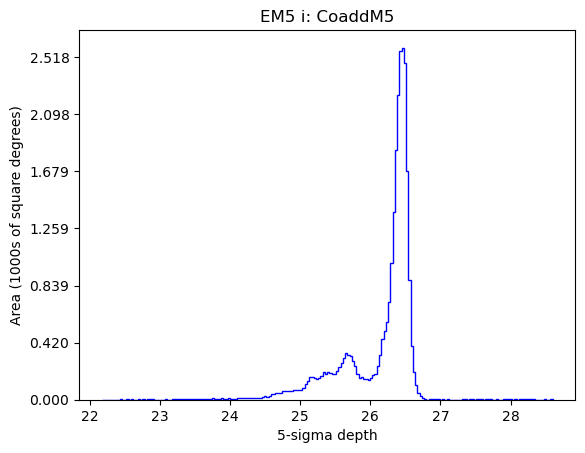

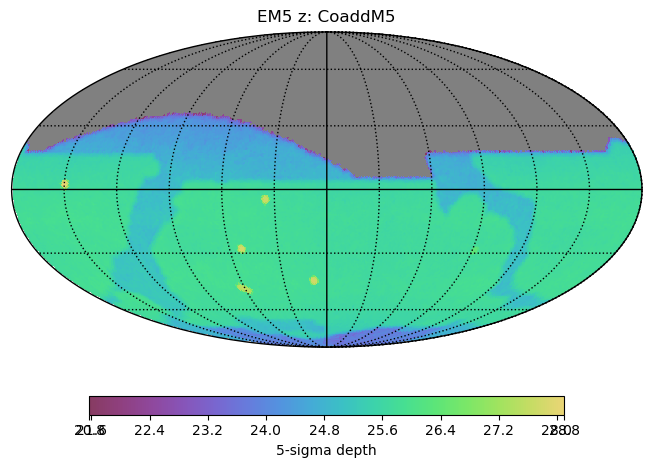

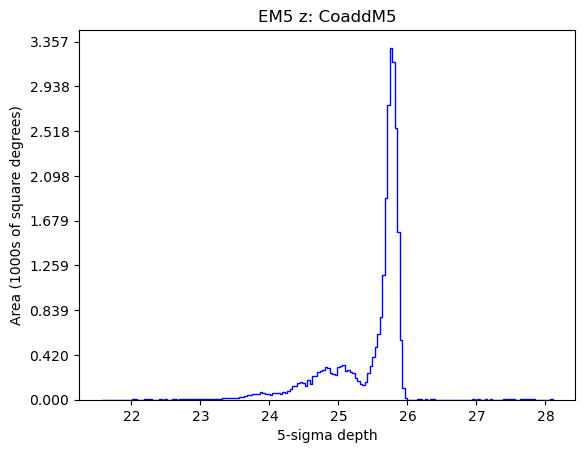

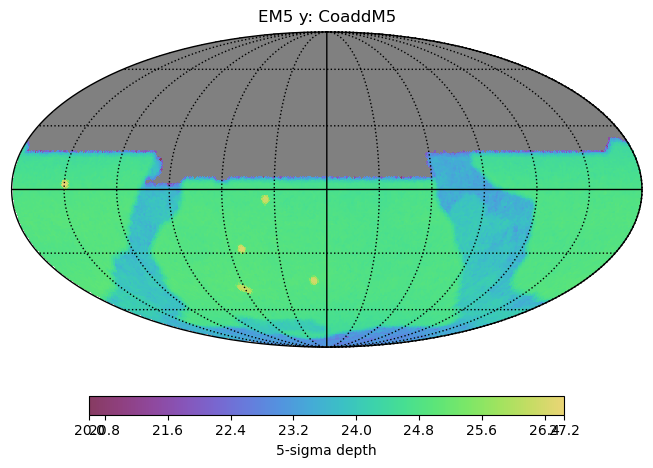

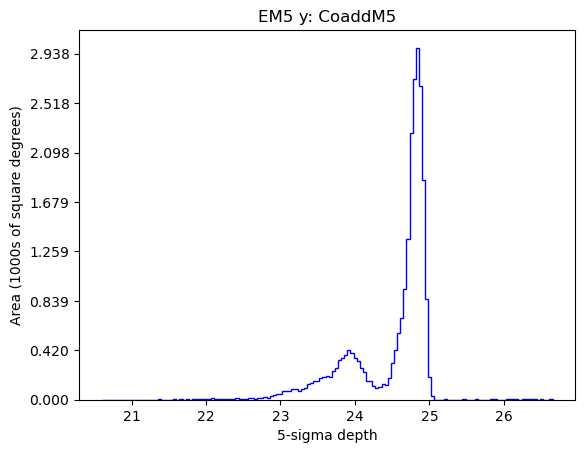

In [3]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

# Define the run name
run_name = 'EM5'

# Create a dictionary to hold MetricBundle objects for each filter
bundles = {}

# Loop through each filter to define and create a MetricBundle for each
for f in filters:
    # Define the SQL constraint for each filter (filter condition)
    constraint = f"filter = '{f}'"
    
    # Create a MetricBundle for each filter using Coaddm5Metric and HealpixSlicer
    # - Coaddm5Metric: Metric used to compute the 5-sigma depth
    # - HealpixSlicer: Divides the sky into pixels (with resolution nside=64)
    bundles[f] = maf.MetricBundle(
        maf.Coaddm5Metric(),               # Metric for 5-sigma depth
        maf.HealpixSlicer(nside=64),       # Slicer for sky area division
        constraint,                         # Filter constraint for this iteration
        run_name=run_name,                  # Name of the survey run
    )

# Define the output directory where the results will be stored
data_dir = './Survey_depth'

# Create a ResultsDb object to store the results of the analysis
resultsDb = maf.db.ResultsDb(out_dir=data_dir)

# Create a MetricBundleGroup object with the MetricBundles for each filter
# - This object will manage and run all the MetricBundles we created
bg = maf.MetricBundleGroup(
    list(bundles.values()),     # List of all MetricBundles created for each filter
    opsdb,                      # Baseline database containing the survey data
    out_dir=data_dir,           # Output directory for the results
    results_db=resultsDb        # Database to store the results
)

# Run the analysis for all MetricBundles in the group
bg.run_all()

# For each filter, plot the results and display them
for f, bundle in bundles.items():
    # Set the plot label for the x-axis
    bundle.set_plot_dict({'xlabel': '5-sigma depth'})
    
    # Plot the results for the current filter
    # - savefig=False ensures the plot is displayed but not saved to a file
    bundle.plot(savefig=False)


In [4]:
nside=64

# Calculate the number of pixels in the sky based on the resolution
npix = 12 * nside**2

# Calculate the area per pixel by dividing the total sky area by the number of pixels
area_per_pixel = 41253 / npix  # Total sky area in square degrees divided by the number of pixels

# Dictionary to store the total area for each filter with valid 5-sigma detections
total_areas = {}

# Loop through each filter to compute the total area with valid 5-sigma detections
for f in filters:
    # Count the number of valid pixels where the 5-sigma depth is greater than 0
    valid_pixels = np.sum(bundles[f].metric_values > 0)
    
    # Calculate the total area for this filter
    total_areas[f] = valid_pixels * area_per_pixel
    
    # Print the total area in square degrees for each filter
    print(f"Total area with 5-sigma detection for filter {f}: {total_areas[f]:.2f} sq deg")


Total area with 5-sigma detection for filter u: 25209.05 sq deg
Total area with 5-sigma detection for filter g: 28112.17 sq deg
Total area with 5-sigma detection for filter r: 28145.74 sq deg
Total area with 5-sigma detection for filter i: 28139.02 sq deg
Total area with 5-sigma detection for filter z: 28121.40 sq deg
Total area with 5-sigma detection for filter y: 25120.92 sq deg


In [5]:
def calculate_5sigma_depth(baseline, nside, maps, outdir, ourdir_db):
    
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    bundles = {}
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
        
        depth_metric = maf.Coaddm5Metric()
        depth_sql = f'filter = "{f}"'
        depth_bundle = maf.MetricBundle(depth_metric, slicer, depth_sql, run_name=run_name, info_label=f'{f} band 5-sigma depth')
        bundles[f] = depth_bundle

    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

In [6]:
# Set parameters
baseline  = get_baseline()
nside     = 64
outdir    = './Survey_depth'
ourdir_db = './Survey_depth'

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
# ['','LMC_SMC','bulge','dusty_plane','lowdust','nes','scp','virgo']
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

# If you want to use a specific map, uncomment the following line
# maps = np.where(map_labels == 'nes')[0]

EM5_depth = calculate_5sigma_depth(baseline, nside, maps, outdir, ourdir_db)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


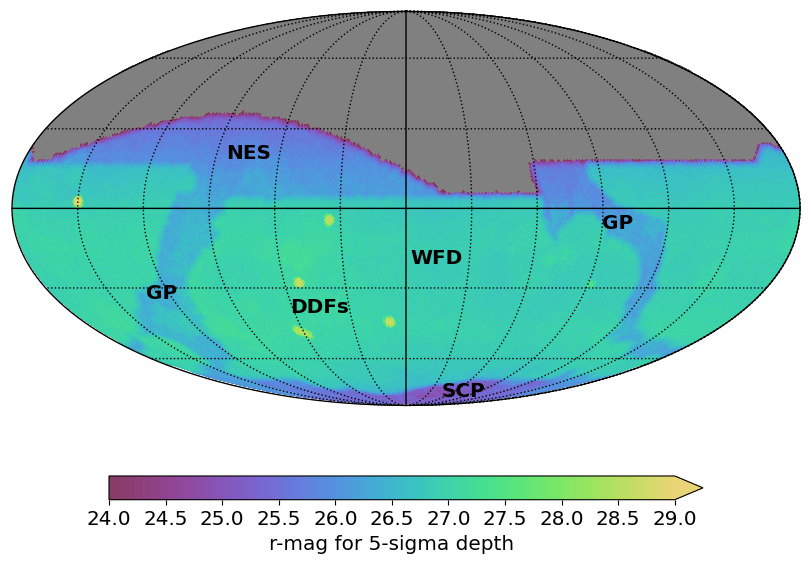

In [7]:
def plot_mollweide_projection(bundles, filter_band, title, xlabel, color_min=None, color_max=None, figformat='png'):
    """
    Plot a Mollweide projection for the specified filter band.

    Parameters:
    bundles (dict): Metric bundles for each filter.
    filter_band (str): Filter band to plot ('u', 'g', 'r', 'i', 'z', 'y').
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    color_min (float, optional): Minimum value for the color bar.
    color_max (float, optional): Maximum value for the color bar.
    out_dir (str, optional): Directory to save the output plot.
    opsim (str, optional): Name of the opsim run.
    figformat (str, optional): Format of the output plot, default is 'png'.

    Returns:
    int: Always returns 0.
    """
    bundle = bundles[filter_band]

    plot_dict = {
        'figsize': (8, 7),
        'labelsize': 'x-large',
        'fontsize': 'x-large',
        'xlabel': xlabel,
        'extend': 'max',
        'title': '',
        'colorbar_location':'top'
    }
    
    if color_min is not None:
        plot_dict['color_min'] = color_min
    if color_max is not None:
        plot_dict['color_max'] = color_max

    ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, dpi=270)
    ph.set_metric_bundles([bundle])
    ph.plot(plot_func=maf.plots.HealpixSkyMap(), plot_dicts=plot_dict)
    #plt.figtext(0.51, 0.45, 'Low-dust\n WFD', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.51, 0.45, 'WFD', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.28, 0.6, 'NES', fontsize='x-large', fontweight='bold', color='black')
    #plt.figtext(0.68, 0.41, 'WFD \n (bulge)', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.18, 0.4, 'GP', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.75, 0.5, 'GP', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.55, 0.26, 'SCP', fontsize='x-large', fontweight='bold', color='black')
    plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
    plt.show()
    
plot_mollweide_projection(EM5_depth, filter_band='r', title='5-sigma Depth in r band', xlabel='r-mag for 5-sigma depth',color_min=24, color_max=29)